# ✅ 1. Exploratory Data Analysis (EDA)


1.   Import library
      Mengimpor pustaka yang diperlukan untuk analisis data dan visualisasi.
2.   Load dataset
      Membaca file CSV berisi data logistik ke dalam DataFrame df.

3. Perbaiki nama kolom
      Menghapus spasi dan karakter aneh pada nama kolom agar konsisten dan mudah diakses.
4. Konversi kolom tanggal
      Mengubah kolom tanggal menjadi format datetime agar bisa digunakan untuk ekstraksi fitur waktu.
5. Ekstraksi hari dan bulan
      Mengambil informasi hari (0 = Senin) dan bulan dari tanggal pengiriman untuk dianalisis lebih lanjut.
6. Bersihkan kolom jarak
    Mengganti koma dengan titik, menghapus karakter non-numerik, lalu mengubah ke tipe float. Nilai kosong diisi dengan rata-rata.
7. Buat kategori jarak
    Mengelompokkan nilai jarak menjadi tiga kategori: Dekat, Sedang, dan Jauh berdasarkan ambang batas tertentu.

In [1]:
# 1. Import Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2.  Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset_Logistik - Sheet1 (1) (1).csv')

In [3]:
# 3. Perbaiki nama kolom
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [4]:
# 4. Konversi tanggal
df['Tanggal_Pengiriman'] = pd.to_datetime(df['Tanggal_Pengiriman'], dayfirst=True, errors='coerce')
df['Tanggal_Estimasi'] = pd.to_datetime(df['Tanggal_Estimasi'], dayfirst=True, errors='coerce')

In [5]:
# 5. Ambil hari & bulan pengiriman sebagai fitur
df['Hari'] = df['Tanggal_Pengiriman'].dt.dayofweek  # Senin = 0
df['Bulan'] = df['Tanggal_Pengiriman'].dt.month

In [6]:
# 6. Bersihkan Jarak
df['Jarak'] = (
    df['Jarak']
    .astype(str)
    .str.replace(',', '.')
    .str.replace(r'[^\d.]+', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)
df['Jarak'] = df['Jarak'].fillna(df['Jarak'].mean())


In [7]:
# 7. Buat Kategori Jarak
def kategori_jarak(jarak):
    if jarak <= 500:
        return 'Dekat'
    elif jarak <= 1000:
        return 'Sedang'
    else:
        return 'Jauh'

df['Kategori_Jarak'] = df['Jarak'].apply(kategori_jarak)

# 🔧 2. Data Preprocessing
1. Bersihkan nama kolom agar mudah dipanggil.

2. Ubah format tanggal ke datetime untuk ambil fitur waktu.

3. Ekstrak hari dan bulan dari tanggal pengiriman.

4. Bersihkan kolom jarak, ubah ke angka, isi nilai kosong dengan rata-rata.

5. Buat kategori jarak: Dekat, Sedang, Jauh berdasarkan nilai numerik.

In [8]:
# 8. Hapus kolom yang menyebabkan leakage
df = df.drop(columns=['ID_Pesanan', 'Tanggal_Pengiriman', 'Tanggal_Terima',
                      'Tanggal_Estimasi', 'Durasi_Pengiriman_Jam', 'Selisih_Estimasi_Jam'], errors='ignore')

In [9]:
# 9. One-Hot Encoding
categorical = ['Lokasi_Pengirim', 'Lokasi_Penerima', 'Kendaraan', 'Jasa_Ekspedisi', 'Kategori_Jarak']
df_encoded = pd.get_dummies(df, columns=categorical, drop_first=True)

In [10]:
# 10. Tangani missing value
df_encoded = df_encoded.dropna(subset=['Pengirima__Tepat_Waktu'])  # target tidak boleh NaN
df_encoded = df_encoded.fillna(df_encoded.mean(numeric_only=True))  # isi sisa NaN

In [11]:
# 11. Pisahkan fitur dan target
X = df_encoded.drop(columns=['Pengirima__Tepat_Waktu'])
y = df_encoded['Pengirima__Tepat_Waktu']

In [12]:
# 12. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

1. Split Data
Memisahkan data menjadi data latih (train) dan data uji (test) dengan rasio 80:20 agar model bisa diuji setelah dilatih.

2. Latih Model Random Forest
Menggunakan algoritma Random Forest Classifier untuk membangun model prediksi berdasarkan data latih.

3. Prediksi dan Evaluasi
Melakukan prediksi pada data uji, lalu mengevaluasi hasilnya menggunakan metrik:

*   Accuracy: seberapa banyak prediksi yang benar
*   Classification report: precision, recall, F1-score
*   Confusion matrix: ringkasan prediksi benar vs salah
4. Analisis Fitur Penting
Menampilkan fitur-fitur yang paling berpengaruh dalam prediksi berdasarkan hasil dari model Random Forest.

In [13]:
# 13. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [14]:
# 14. Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [15]:
# 15. Prediksi dan Evaluasi
y_pred = model.predict(X_test)

print("🎯 Akurasi:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\n📋 Laporan Klasifikasi:\n", classification_report(y_test, y_pred))

🎯 Akurasi: 80.0 %

📋 Laporan Klasifikasi:
               precision    recall  f1-score   support

         0.0       0.50      0.25      0.33         4
         1.0       0.83      0.94      0.88        16

    accuracy                           0.80        20
   macro avg       0.67      0.59      0.61        20
weighted avg       0.77      0.80      0.77        20



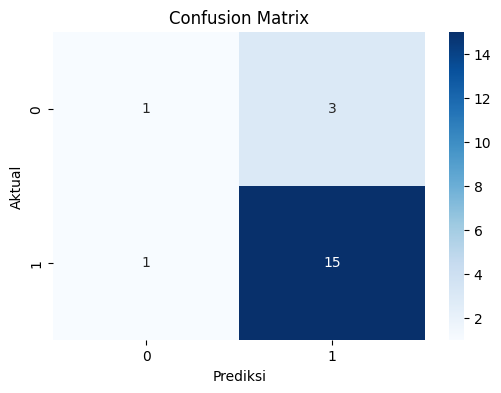

In [16]:
# 16. Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


🔥 10 Fitur Terpenting:
                                             Fitur  Importance
0                                            Jarak    0.162167
2                                            Bulan    0.148774
1                                             Hari    0.108761
68   Jasa_Ekspedisi_J&T Express Pengiriman Standar    0.034116
17                   Lokasi_Pengirim_Jakarta Timur    0.024463
75                     Jasa_Ekspedisi_SPX Standard    0.022919
51                       Lokasi_Pengirim_Tangerang    0.022532
82          Jasa_Ekspedisi_Shopee Express Standard    0.018447
73                        Jasa_Ekspedisi_SPX Hemat    0.018144
79  Jasa_Ekspedisi_Shopee Express Pengiriman Hemat    0.017927


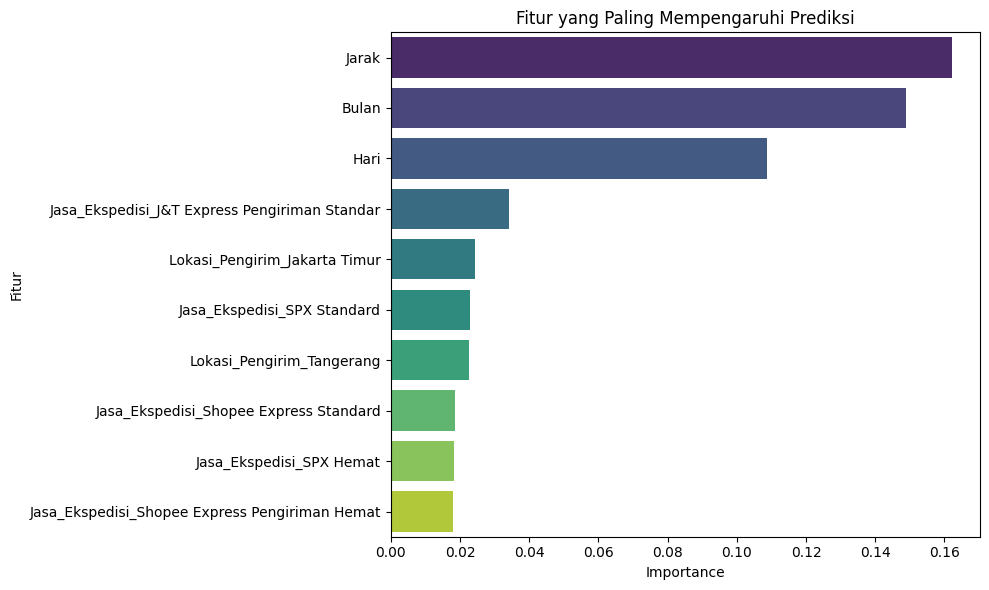

In [17]:
# 17. Fitur Terpenting
importances = model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Fitur': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

print("\n🔥 10 Fitur Terpenting:")
print(feat_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Fitur', data=feat_df.head(10), palette='viridis')
plt.title('Fitur yang Paling Mempengaruhi Prediksi')
plt.xlabel('Importance')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()